In [1]:
import copy
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
# Read data
#data = fetch_california_housing()
#X, y = data.data, data.target
df = pd.read_csv('loading_data_max.csv')
df=df.drop_duplicates()

X = df.drop(['filling_space_percent','density_percent'], axis=1)
#X = df['cargo_volume']
y = df['filling_space_percent']/100
y

0      0.817233
1      0.515625
2      0.642438
3      0.672980
4      0.582632
         ...   
620    0.767428
622    0.831830
625    0.000025
626    0.000050
627    0.000248
Name: filling_space_percent, Length: 510, dtype: float64

In [3]:
# train-test split for model evaluation
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True,random_state=11)

# Standardizing data
scaler = MinMaxScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Convert to 2D PyTorch tensors
'''X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)'''

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
 


In [4]:
# Define the model
model = nn.Sequential(
    nn.Linear(32, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, 1)

)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0005)
 


In [5]:
n_epochs = 4000   # number of epochs to run
batch_size = 510  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} | R^2_NNRegressor: {r2_score(y_test.detach().numpy(), y_pred.detach().numpy()):.4f} MSE:{mse:.4f}')


Epoch: 0 | R^2_NNRegressor: -2.5064 MSE:0.2283
Epoch: 50 | R^2_NNRegressor: 0.7333 MSE:0.0174
Epoch: 100 | R^2_NNRegressor: 0.8430 MSE:0.0102
Epoch: 150 | R^2_NNRegressor: 0.8593 MSE:0.0092
Epoch: 200 | R^2_NNRegressor: 0.8724 MSE:0.0083
Epoch: 250 | R^2_NNRegressor: 0.8852 MSE:0.0075
Epoch: 300 | R^2_NNRegressor: 0.8983 MSE:0.0066
Epoch: 350 | R^2_NNRegressor: 0.9103 MSE:0.0058
Epoch: 400 | R^2_NNRegressor: 0.9173 MSE:0.0054
Epoch: 450 | R^2_NNRegressor: 0.9230 MSE:0.0050
Epoch: 500 | R^2_NNRegressor: 0.9298 MSE:0.0046
Epoch: 550 | R^2_NNRegressor: 0.9358 MSE:0.0042
Epoch: 600 | R^2_NNRegressor: 0.9417 MSE:0.0038
Epoch: 650 | R^2_NNRegressor: 0.9465 MSE:0.0035
Epoch: 700 | R^2_NNRegressor: 0.9526 MSE:0.0031
Epoch: 750 | R^2_NNRegressor: 0.9562 MSE:0.0028
Epoch: 800 | R^2_NNRegressor: 0.9602 MSE:0.0026
Epoch: 850 | R^2_NNRegressor: 0.9634 MSE:0.0024
Epoch: 900 | R^2_NNRegressor: 0.9659 MSE:0.0022
Epoch: 950 | R^2_NNRegressor: 0.9684 MSE:0.0021
Epoch: 1000 | R^2_NNRegressor: 0.9696 MSE:

MSE: 0.00
RMSE: 0.03


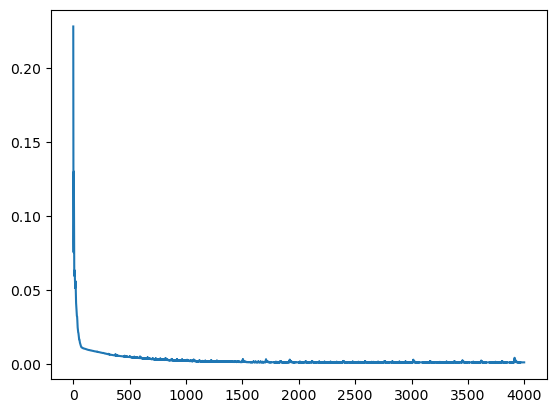

In [6]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

<AxesSubplot:xlabel='0', ylabel='0'>

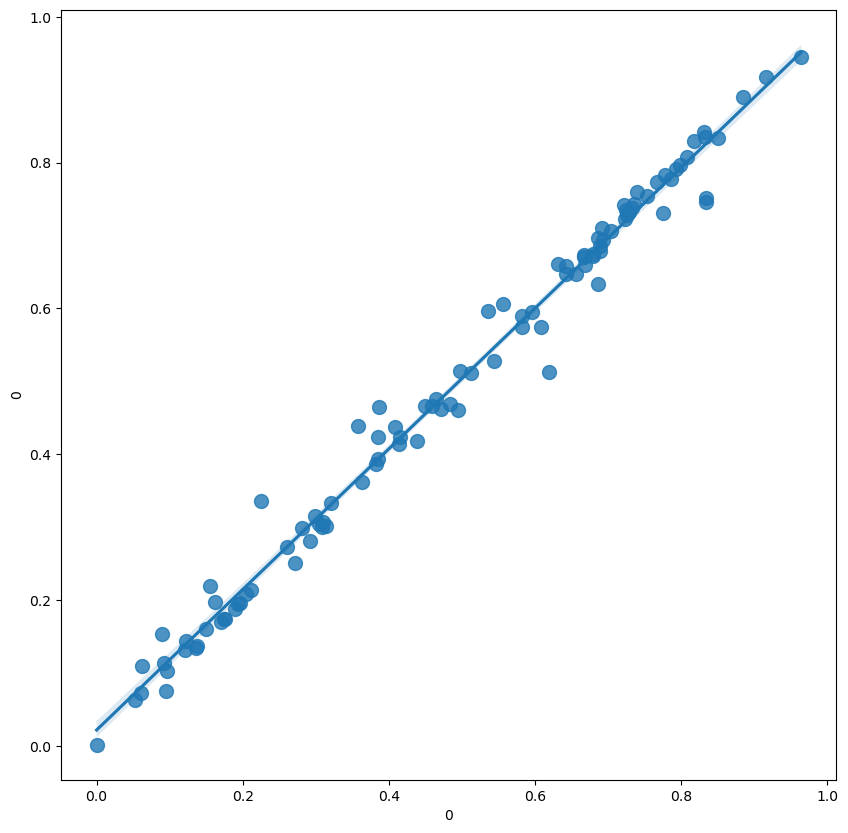

In [7]:
model.eval()
y_pred = model(X_test)
plt.figure(figsize=(10,10))
y_test=pd.DataFrame(y_test)
y_pred=pd.DataFrame(y_pred.detach().numpy())
sns.regplot(x=y_test, y=y_pred, fit_reg=True, scatter_kws={"s": 100})

In [8]:
y_test=pd.DataFrame(y_test)
y_pred=pd.DataFrame(y_pred.detach().numpy())

AttributeError: 'DataFrame' object has no attribute 'detach'

In [ ]:
model.eval()
y_t=[]
y_p=np.array
with torch.no_grad():
    # Test out inference with 5 samples
    
        X_sample = X_test_raw
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        #print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")
        print(X_sample)

        print(y_pred[0].numpy())
        print(y_test[0].numpy())
